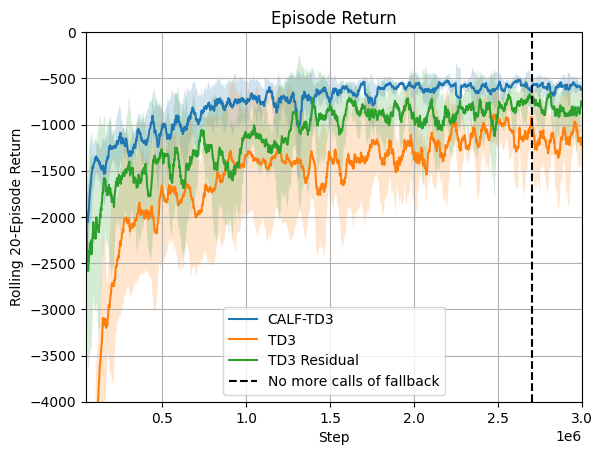

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
from scipy.optimize import root_scalar


calfq_data = pd.read_csv("expdata/calfq_update.csv")
td3_data = pd.read_csv("expdata/td3_update.csv")
td3_residual_data = pd.read_csv("expdata/residual_td3.csv")


def select_metrics(data, metric_name):
    return data[data["key"] == metric_name]


means = (
    select_metrics(calfq_data, "charts/episodic_return_rolling_20")
    .groupby("step")["value"]
    .mean()
)
stds = (
    select_metrics(calfq_data, "charts/episodic_return_rolling_20")
    .groupby("step")["value"]
    .std()
)

plt.plot(means, label="CALF-TD3")
plt.fill_between(means.index, means - stds, means + stds, alpha=0.2)
# plt.axhline(y=-700, color="black", linestyle="--")
means = (
    select_metrics(td3_data, "charts/episodic_return_rolling_20")
    .groupby("step")["value"]
    .mean()
)
stds = (
    select_metrics(td3_data, "charts/episodic_return_rolling_20")
    .groupby("step")["value"]
    .std()
)
plt.plot(means, label="TD3")
plt.fill_between(means.index, means - stds, means + stds, alpha=0.2)


means = (
    select_metrics(td3_residual_data, "charts/episodic_return_rolling_20")
    .groupby("step")["value"]
    .mean()
)
stds = (
    select_metrics(td3_residual_data, "charts/episodic_return_rolling_20")
    .groupby("step")["value"]
    .std()
)
plt.plot(means, label="TD3 Residual")
plt.fill_between(means.index, means - stds, means + stds, alpha=0.2)


plt.axvline(
    x=0.9 * 3_000_000, color="black", linestyle="--", label="No more calls of fallback"
)
plt.xlim(45_000, 3_000_000)
plt.ylim(-4000, 0)
plt.legend()
plt.title("Episode Return")
plt.xlabel("Step")
plt.ylabel("Rolling 20-Episode Return")
plt.grid()
plt.savefig("../gfx/episode_return_calf_td3_vs_td3.png")

In [6]:
print("CALFQ GOAL REACHING RATE AFTER 2.7M STEPS (closer to 1 is better)")

is_in_hole = select_metrics(calfq_data, "episode_stats/is_in_hole")
is_in_hole = is_in_hole[is_in_hole["step"] >= 2_700_000]
print(
    is_in_hole.groupby("run_id")["value"].mean().mean(),
    "+-",
    is_in_hole.groupby("run_id")["value"].mean().std(),
)

print("TD3 GOAL REACHING RATE AFTER 2.7M STEPS (closer to 1 is better)")
is_in_hole = select_metrics(td3_data, "episode_stats/is_in_hole")
is_in_hole = is_in_hole[is_in_hole["step"] >= 2_700_000]
print(
    is_in_hole.groupby("run_id")["value"].mean().mean(),
    "+-",
    is_in_hole.groupby("run_id")["value"].mean().std(),
)

print("TD3 RESIDUAL GOAL REACHING RATE AFTER 2.7M STEPS (closer to 1 is better)")
is_in_hole = select_metrics(td3_residual_data, "episode_stats/is_in_hole")
is_in_hole = is_in_hole[is_in_hole["step"] >= 2_700_000]
print(
    is_in_hole.groupby("run_id")["value"].mean().mean(),
    "+-",
    is_in_hole.groupby("run_id")["value"].mean().std(),
)
print("--------------------------------")

print("CALFQ HIGH COST REGION AVOIDANCE SCORE AFTER 2.7M STEPS (closer to 0 is better)")
high_cost_region = select_metrics(calfq_data, "episode_stats/avoidance_score")
high_cost_region = high_cost_region[high_cost_region["step"] >= 2_700_000]
print(
    high_cost_region.groupby("run_id")["value"].mean().mean(),
    "+-",
    high_cost_region.groupby("run_id")["value"].mean().std(),
)

print("TD3 HIGH COST REGION AVOIDANCE SCORE AFTER 2.7M STEPS (closer to 0 is better)")
high_cost_region = select_metrics(td3_data, "episode_stats/avoidance_score")
high_cost_region = high_cost_region[high_cost_region["step"] >= 2_700_000]
print(
    high_cost_region.groupby("run_id")["value"].mean().mean(),
    "+-",
    high_cost_region.groupby("run_id")["value"].mean().std(),
)

print("TD3 RESIDUAL HIGH COST REGION AVOIDANCE SCORE AFTER 2.7M STEPS (closer to 0 is better)")
high_cost_region = select_metrics(td3_residual_data, "episode_stats/avoidance_score")
high_cost_region = high_cost_region[high_cost_region["step"] >= 2_700_000]
print(
    high_cost_region.groupby("run_id")["value"].mean().mean(),
    "+-",
    high_cost_region.groupby("run_id")["value"].mean().std(),
)
print("--------------------------------")


CALFQ GOAL REACHING RATE AFTER 2.7M STEPS (closer to 1 is better)
0.991 +- 0.00741619848709567
TD3 GOAL REACHING RATE AFTER 2.7M STEPS (closer to 1 is better)
0.5349999999999999 +- 0.4189868733027325
TD3 RESIDUAL GOAL REACHING RATE AFTER 2.7M STEPS (closer to 1 is better)
0.9450000000000001 +- 0.0413823633931171
--------------------------------
CALFQ HIGH COST REGION AVOIDANCE SCORE AFTER 2.7M STEPS (closer to 0 is better)
0.009219458758434827 +- 0.003030517498842916
TD3 HIGH COST REGION AVOIDANCE SCORE AFTER 2.7M STEPS (closer to 0 is better)
0.018969037227252177 +- 0.008048283216214508
TD3 RESIDUAL HIGH COST REGION AVOIDANCE SCORE AFTER 2.7M STEPS (closer to 0 is better)
0.017721946462804887 +- 0.005979002524906335
--------------------------------


In [4]:
from scipy.optimize import fsolve


def dD2(y, x0, y0):
    return -9 * (y - 2) * (0.81 - x0 - 2.25 * (y - 2) ** 2) + 2 * (y - y0)


root = fsolve(dD2, x0=1.5, args=(1, 1))

In [12]:
def distance_to_parabola(x0, y0):
    """
    Computes the shortest distance from point (x0, y0) to the parabola
    x = 0.81 - 2.25(y - 2)^2.

    Returns:
        distance: float - the shortest distance
        x_closest: float - x-coordinate on the parabola
        y_closest: float - y-coordinate on the parabola
    """
    from scipy.optimize import fsolve
    import numpy as np

    def dD2(y):
        return -9 * (y - 2) * (0.81 - x0 - 2.25 * (y - 2) ** 2) + 2 * (y - y0)

    y_closest = fsolve(dD2, x0=y0)[0]
    x_closest = 0.81 - 2.25 * (y_closest - 2) ** 2
    distance = np.sqrt((x_closest - x0) ** 2 + (y_closest - y0) ** 2)

    return distance

In [16]:
for i in range(1500):
    distance_to_parabola(3, 1)

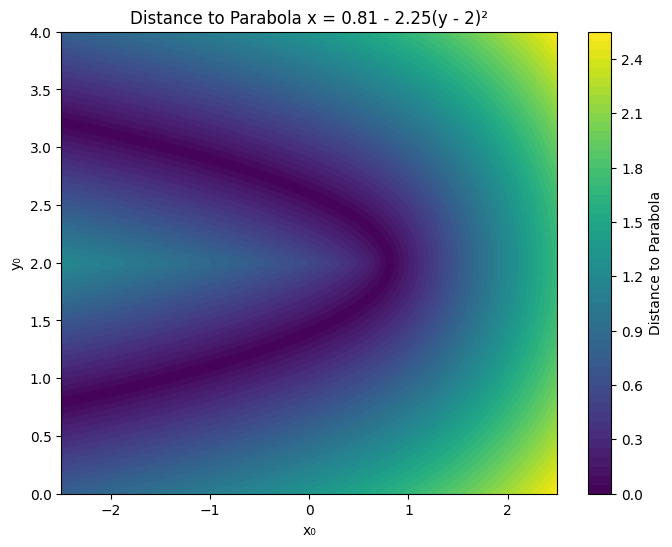

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Your function
from scipy.optimize import minimize_scalar
import numpy as np


def distance_to_parabola(x0, y0):
    """
    Robustly computes the shortest distance from point (x0, y0)
    to the parabola x = 0.81 - 2.25(y - 2)^2 using scalar minimization.

    Returns:
        distance: float - shortest distance
        x_closest: float - x on the parabola
        y_closest: float - y on the parabola
    """

    def D2(y):  # Squared distance function
        x_parabola = 0.81 - 2.25 * (y - 2) ** 2
        return (x_parabola - x0) ** 2 + (y - y0) ** 2

    result = minimize_scalar(D2, bounds=(0, 4), method="bounded")
    distance = np.sqrt(result.fun)

    return distance


# Create grid of x0 and y0 values
x_vals = np.linspace(-2.5, 2.5, 100)
y_vals = np.linspace(0, 4, 100)
X, Y = np.meshgrid(x_vals, y_vals)

# Evaluate distance at each point
Z = np.vectorize(distance_to_parabola)(X, Y)

# Plot as a heatmap
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z, levels=50, cmap="viridis")
plt.colorbar(contour, label="Distance to Parabola")
plt.title("Distance to Parabola x = 0.81 - 2.25(y - 2)²")
plt.xlabel("x₀")
plt.ylabel("y₀")
plt.show()

In [25]:
0.81 / 0.36

2.2500000000000004

In [2]:
from pathlib import Path
import json

p = Path(
    "/home/user/Repos/calfq-td3/run/mlruns/283352061287474666/104d90fa54b14952908033257381781d/artifacts/trajectories"
)

for path in sorted(p.glob("*.json")):
    with open(path, "r") as f:
        data = json.load(f)

    x = data[0]["obs"][0][0]
    y = data[0]["obs"][0][1]

    if x < 0 and x > -0.5:
        print(path)

/home/user/Repos/calfq-td3/run/mlruns/283352061287474666/104d90fa54b14952908033257381781d/artifacts/trajectories/0000014999.json
/home/user/Repos/calfq-td3/run/mlruns/283352061287474666/104d90fa54b14952908033257381781d/artifacts/trajectories/0000020999.json
/home/user/Repos/calfq-td3/run/mlruns/283352061287474666/104d90fa54b14952908033257381781d/artifacts/trajectories/0000025499.json
/home/user/Repos/calfq-td3/run/mlruns/283352061287474666/104d90fa54b14952908033257381781d/artifacts/trajectories/0000026999.json
/home/user/Repos/calfq-td3/run/mlruns/283352061287474666/104d90fa54b14952908033257381781d/artifacts/trajectories/0000031499.json
/home/user/Repos/calfq-td3/run/mlruns/283352061287474666/104d90fa54b14952908033257381781d/artifacts/trajectories/0000034499.json
/home/user/Repos/calfq-td3/run/mlruns/283352061287474666/104d90fa54b14952908033257381781d/artifacts/trajectories/0000041999.json
/home/user/Repos/calfq-td3/run/mlruns/283352061287474666/104d90fa54b14952908033257381781d/artifac